**Time series forecasting using regression algorithm**

In [ ]:
#All imports

import warnings
warnings.filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Reading and Understanding**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AV_TimeSeriesAnalysis/Train.csv')
train_df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AV_TimeSeriesAnalysis/Test.csv')
test_df.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [ ]:
#converting the datetime column from object to datetime
train_df['Datetime'] = pd.to_datetime(train_df['Datetime'], format="%d-%m-%Y %H:%M", errors="coerce").fillna(pd.to_datetime(train_df['Datetime'], format="%d/%m/%Y %H:%M", errors="coerce"))
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'], format="%d-%m-%Y %H:%M", errors="coerce").fillna(pd.to_datetime(test_df['Datetime'], format="%d/%m/%Y %H:%M", errors="coerce"))

In [ ]:
test_df['Date'] = test_df['Datetime'].dt.date

In [ ]:
test_df.head()

,ID,Datetime,Date
0,18288,2014-09-26 00:00:00,2014-09-26
1,18289,2014-09-26 01:00:00,2014-09-26
2,18290,2014-09-26 02:00:00,2014-09-26
3,18291,2014-09-26 03:00:00,2014-09-26
4,18292,2014-09-26 04:00:00,2014-09-26


In [ ]:
test_df.groupby('Date').sum().reset_index()

,Date,ID
0,2014-09-26,439188
1,2014-09-27,439764
2,2014-09-28,440340
3,2014-09-29,440916
4,2014-09-30,441492
...,...,...
208,2015-04-22,558996
209,2015-04-23,559572
210,2015-04-24,560148
211,2015-04-25,560724


In [ ]:
#check if time values are equally spaced
time_shift = train_df['Datetime'].shift(1)
time_diff = train_df['Datetime'] - time_shift
time_diff.value_counts()

0 days 01:00:00    18287
Name: Datetime, dtype: int64

In [ ]:
?datetime.timedelta

Object `datetime.timedelta` not found.


In [ ]:
train_max_date = train_df['Datetime'].max()
test_max_date = test_df['Datetime'].max()
out_lag = (test_max_date - train_max_date).days*24
print ("train max date: {} test max date: {} Out lag: {}".format(train_max_date, test_max_date, out_lag))

train max date: 2014-09-25 23:00:00 test max date: 2015-04-26 23:00:00 Out lag: 5112


**Considering univariate time series**

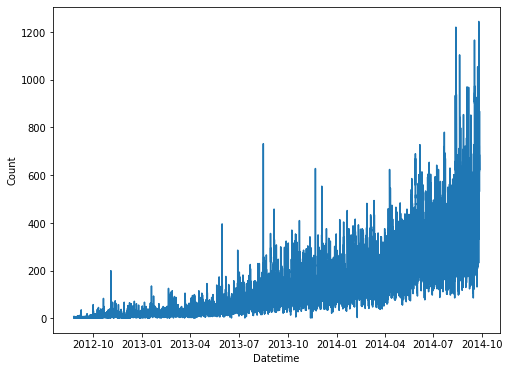

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(x=train_df['Datetime'], y=train_df['Count'])
plt.show()

In [ ]:
#extract more features for visualization
train_df['year'] = train_df['Datetime'].dt.year
train_df['month'] = train_df['Datetime'].dt.month
train_df['week'] = train_df['Datetime'].dt.weekofyear

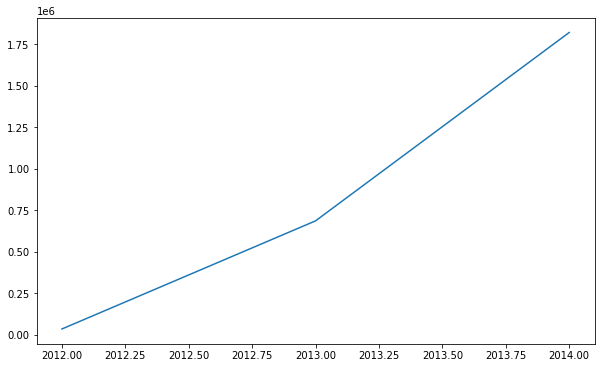

In [ ]:
#visualize count of passengers year-wise
plt.figure(figsize=(10,6))
count_by_year = train_df[['year', 'Count']].groupby(by=['year']).sum()
plt.plot(count_by_year)

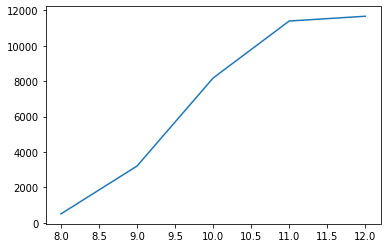

In [ ]:
#visualize passengers count month-wise for each year
count_by_month_2012 = train_df[train_df['year'] == 2012][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2012)

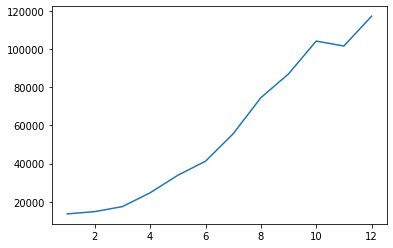

In [ ]:
count_by_month_2013 = train_df[train_df['year'] == 2013][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2013)

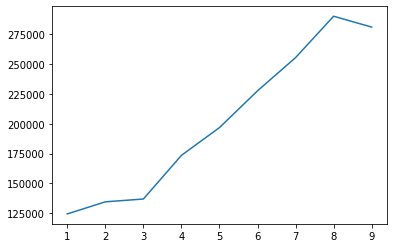

In [ ]:
count_by_month_2014 = train_df[train_df['year'] == 2014][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2014)

**From plots above, there is a coninous increasing trend in passangers**

In [ ]:
X = train_df['Count']
y = train_df['Count'].shift(-out_lag)

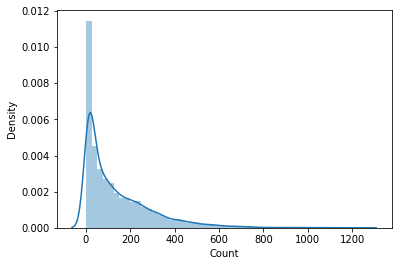

In [ ]:
#see the distribution of count of passengers
sns.distplot(X)
plt.show()

In [ ]:
cols, names = list(), list(['Count'])
for i in range(1, 31, 1):
  cols.append(X.shift(i))
  names.append("Count-{}".format(i))

features = pd.concat(cols, axis=1)
X_features = pd.concat([X, features], axis=1)
X_features.columns = names
X_features.fillna(0, inplace=True)

In [ ]:
X_features = X
X_features = np.array(X_features).reshape(-1,1)

**Modelling**

In [ ]:
X_test = X_features[-5112:]
X_features = X_features[:-5112]
y = y[:-5112]

split_index = int(len(X_features)*0.80)
X_train, y_train = X_features[0:split_index], y[0:split_index]
X_val, y_val = X_features[split_index:] , y[split_index:]

**Linear Regression**

In [ ]:
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
train_prediction = lm.predict(X_train)
print ("train rmse: ",np.sqrt(mean_squared_error(y_train, train_prediction)))

val_prediction = lm.predict(X_val)
print ("val rmse: ",np.sqrt(mean_squared_error(y_val, val_prediction)))

train rmse:  84.17095802141296
val rmse:  207.09513497049394


In [ ]:
y_test = lm.predict(X_test)

**Test submission**

In [ ]:
test_predictions = pd.DataFrame({'ID':test_df['ID'], 'Count':y_test})
test_predictions.to_csv('./submission.csv', index=False)